# Rapid prototyping camera applications

Welcome to this IDS Vision Channel Session.

jupyter-lab is the application that runs jupyter-notebooks.

**Hi There**

In [2]:
!pip install ids_peak


  Using cached ids_peak-1.10.0.0.4-cp37-abi3-win_amd64.whl.metadata (15 kB)
  Using cached ids_peak_ipl-1.15.0.0.3-cp311-abi3-win_amd64.whl.metadata (12 kB)
Using cached ids_peak-1.10.0.0.4-cp37-abi3-win_amd64.whl (3.8 MB)
Using cached ids_peak_ipl-1.15.0.0.3-cp311-abi3-win_amd64.whl (6.7 MB)


## Camera Access with IDS peak

Download complete IDS peak package from IDS website: https://en.ids-imaging.com/download-details/AB02611.html#drivers

Includes camera drivers, software, tools, documentation, and the IDS peak API in C++, .NET, and Python. Available for Windows and Linux, including various embedded platforms.

Install peak Python:

```
python -m pip install ids_peak
```

peak API Reference Documentation is installed locally:

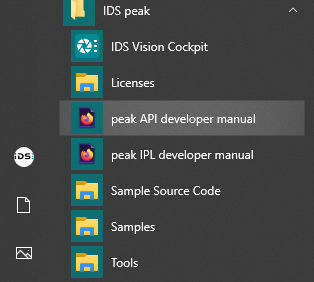

Additional documentation and guides are available at the IDS website:
* https://en.ids-imaging.com/download-details/AB02611.html#documents
* https://en.ids-imaging.com/knowledge-base.html


### Find Connected Cameras

In [3]:
import ids_peak.ids_peak as ids_peak

ids_peak.Library.Initialize()
device_manager = ids_peak.DeviceManager.Instance()
device_manager.Update()
device_descriptors = device_manager.Devices()

print("Found Devices: " + str(len(device_descriptors)))
for device_descriptor in device_descriptors:
    print(device_descriptor.DisplayName())

Found Devices: 1
IDS Imaging Development Systems GmbH U3-326xCP-M (1409f4a696efU3-326xCP-M-0)


### Open Camera

In [4]:
device = device_descriptors[0].OpenDevice(ids_peak.DeviceAccessType_Control)
print("Opened Device: " + device.DisplayName())
remote_device_nodemap = device.RemoteDevice().NodeMaps()[0]

Opened Device: IDS Imaging Development Systems GmbH U3-326xCP-M (1409f4a696efU3-326xCP-M-0)


### Set software trigger mode
We don't need the camera to run continuously in the background. Instead we use the software trigger to capture an image just when we want to.

In [4]:
remote_device_nodemap.FindNode("TriggerSelector").SetCurrentEntry("ExposureStart")
remote_device_nodemap.FindNode("TriggerSource").SetCurrentEntry("Software")
remote_device_nodemap.FindNode("TriggerMode").SetCurrentEntry("On")

Errors are displayed immediately. No output means no errors.

### Start image acquisition

In [5]:
datastream = device.DataStreams()[0].OpenDataStream()
payload_size = remote_device_nodemap.FindNode("PayloadSize").Value()
for i in range(datastream.NumBuffersAnnouncedMinRequired()):
    buffer = datastream.AllocAndAnnounceBuffer(payload_size)
    datastream.QueueBuffer(buffer)
    
datastream.StartAcquisition()
remote_device_nodemap.FindNode("AcquisitionStart").Execute()
remote_device_nodemap.FindNode("AcquisitionStart").WaitUntilDone()

## Change camera settings
### Exposure Time

In [12]:
remote_device_nodemap.FindNode("ExposureTime").SetValue(1000) # in microseconds

### Mirror/Flip Image

In [ ]:
remote_device_nodemap.FindNode("ReverseX").SetValue(False)
remote_device_nodemap.FindNode("ReverseY").SetValue(False)

## Grab a Single Image

1. Execute software trigger 
2. Wait for image
3. Use IDS peak IPL (Image Processing Library) to convert image from Bayer to RGB
4. Display image

```
python -m pip install ids_peak_ipl
pip install matplotlib
```

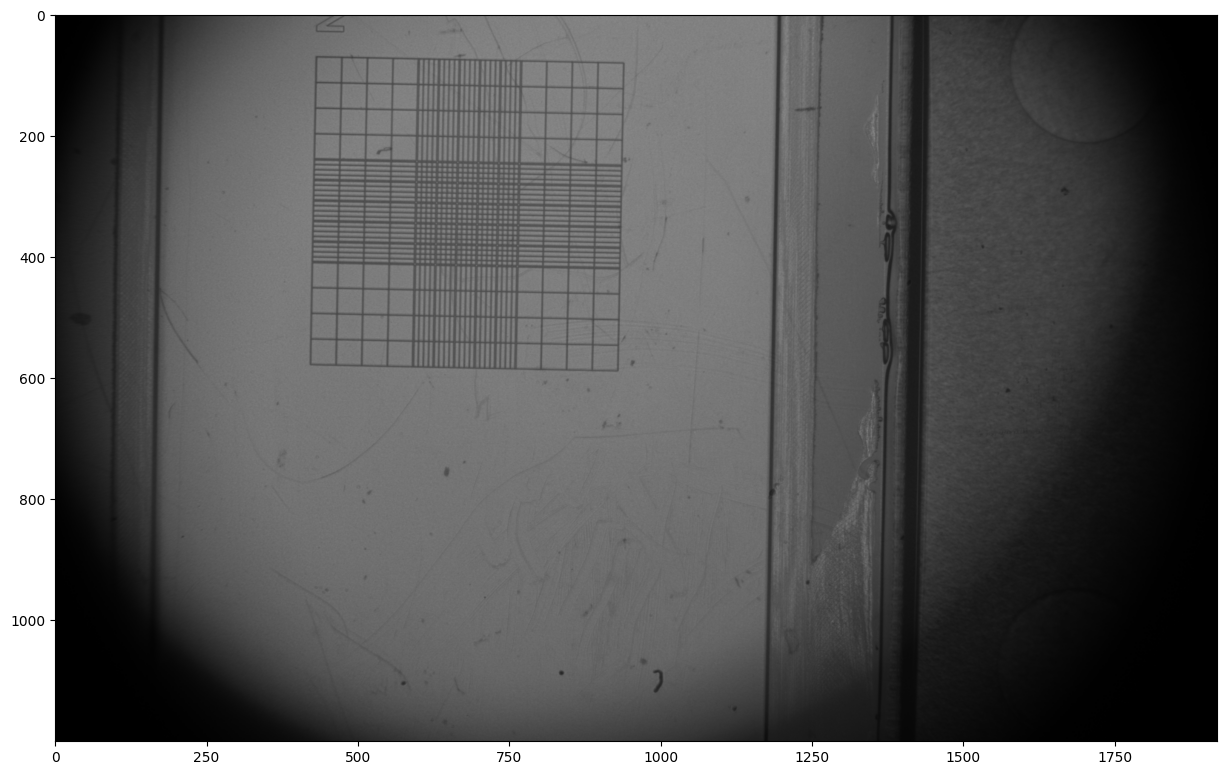

In [13]:
# trigger image
remote_device_nodemap.FindNode("TriggerSoftware").Execute()
buffer = datastream.WaitForFinishedBuffer(1000)

# convert to RGB
import ids_peak_ipl.ids_peak_ipl as ids_ipl
import ids_peak.ids_peak_ipl_extension as ids_ipl_extension
raw_image = ids_ipl_extension.BufferToImage(buffer)
# for Peak version 2.0.1 and lower, use this function instead of the previous line:
#raw_image = ids_ipl.Image_CreateFromSizeAndBuffer(buffer.PixelFormat(), buffer.BasePtr(), buffer.Size(), buffer.Width(), buffer.Height())
color_image = raw_image.ConvertTo(ids_ipl.PixelFormatName_RGB8)
datastream.QueueBuffer(buffer)

import numpy as np
picture = color_image.get_numpy_3D()

# display the image
from matplotlib import pyplot as plt
plt.figure(figsize = (15,15))
plt.imshow(picture)

## Basic Image Operations

### Image Size?

In [8]:
picture.shape

(1080, 1440, 3)

(Rows, Columns, Channels <RGB = 3>)

### Let's have look at the data

The first 10 pixels in row 100:

In [9]:
picture[100,0:10,:]

array([[18, 14, 10],
       [16, 14, 10],
       [14, 13, 10],
       [14, 11, 10],
       [15, 12, 12],
       [16, 13, 14],
       [18, 16, 16],
       [18, 20, 18],
       [18, 20, 19],
       [18, 20, 20]], dtype=uint8)

### Change the image
Turn the top left corner red

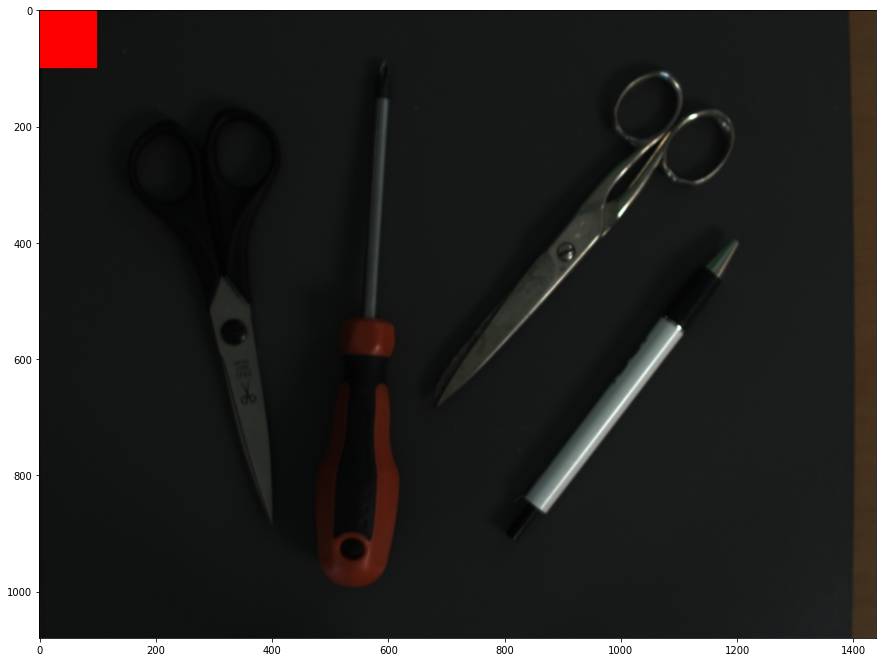

In [10]:
picture[0:100,0:100,:] = [255,0,0]

# display the image
from matplotlib import pyplot as plt
plt.figure(figsize = (15,15))
plt.imshow(picture)

### ROI

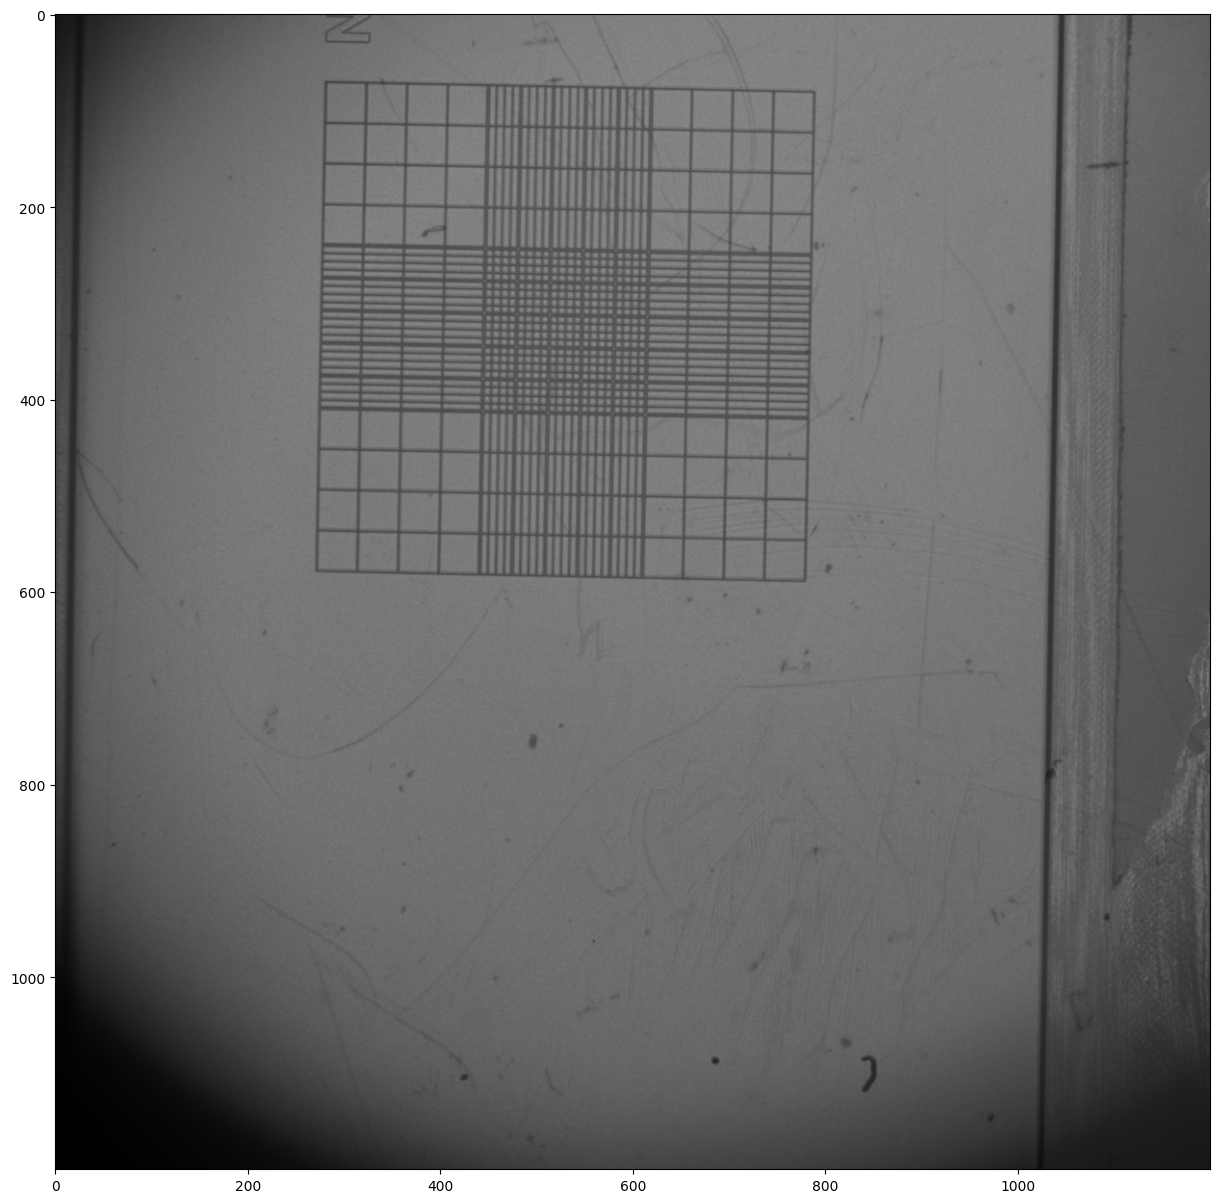

In [14]:
picture_roi = picture[:,150:1350,:]

plt.figure(figsize = (15,15))
plt.imshow(picture_roi)

### Split Colors

In [ ]:
fig,ax=plt.subplots(nrows=1,ncols=3,figsize=(15,5))
for i in range(3):
    component = np.zeros(picture_roi.shape,dtype="uint8")
    component[:,:,i] = picture_roi[:,:,i]
    ax[i].imshow(component)

## OpenCV
The most popular free, open-source, real-time computer vision: https://opencv.org/

Extensive functionality, e.g. color conversions, transformations, smoothing and other filters, edge detection, feature detection and tracking, ...
With lots of documentation and tutorials, e.g. Python tutorials: https://docs.opencv.org/4.5.2/d6/d00/tutorial_py_root.html

Simply install with:
```
pip install opencv-python
```

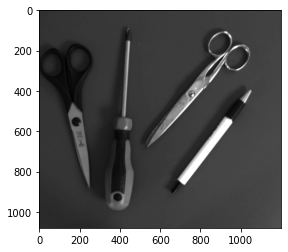

In [17]:
import cv2
gray_image = cv2.cvtColor(picture_roi, cv2.COLOR_RGB2GRAY)
plt.imshow(gray_image, cmap='gray')

### Histogram
https://docs.opencv.org/4.5.2/d6/dc7/group__imgproc__hist.html#ga4b2b5fd75503ff9e6844cc4dcdaed35d

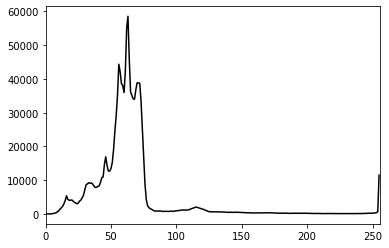

In [18]:
plt.xlim([0, 256])
hist = cv2.calcHist([gray_image], [0], None, [256], [0, 256])
plt.plot(hist, color="Black")

### Color Histogram

In [ ]:
plt.xlim([0, 256])
colors = ["Red", "Green", "Blue"]
for i in range(3):
    hist = cv2.calcHist([picture_roi], [i], None, [256], [0, 256])
    plt.plot(hist, color=colors[i])

## AI / Deep learning
### PyTorch

* developed by Facebook's AI Research lab (FAIR)
* Python, hardware acceleration with CUDA, along with C/C++ libraries
* https://pytorch.org/

Install with: 
```
pip install torch
```

### Download pre-trained model
Download and initialized the pre-trained YOLOv5 (You-Only-Look-Once) deep learning model 

https://github.com/ultralytics/yolov5#readme

Install instructions: https://github.com/ultralytics/yolov5#requirements

In [19]:
import torch

# Model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s')

Using cache found in C:\Users\jun/.cache\torch\hub\ultralytics_yolov5_master

                 from  n    params  module                                  arguments                     
  0                -1  1      3520  models.common.Focus                     [3, 32, 3]                    
  1                -1  1     18560  models.common.Conv                      [32, 64, 3, 2]                
  2                -1  1     18816  models.common.C3                        [64, 64, 1]                   
  3                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  4                -1  1    156928  models.common.C3                        [128, 128, 3]                 
  5                -1  1    295424  models.common.Conv                      [128, 256, 3, 2]              
  6                -1  1    625152  models.common.C3                        [256, 256, 3]                 
  7                -1  1   1180672  models.common.Conv            

Adding autoShape... 


### Inference / Object Detection
Apply model to ROI image to detect...things

In [20]:
results = model(picture_roi)
results.print()

image 1/1: 1080x1200 5 scissorss
Speed: 0.0ms pre-process, 207.2ms inference, 9.1ms NMS per image at shape (1, 3, 576, 640)


### Draw Inference Results

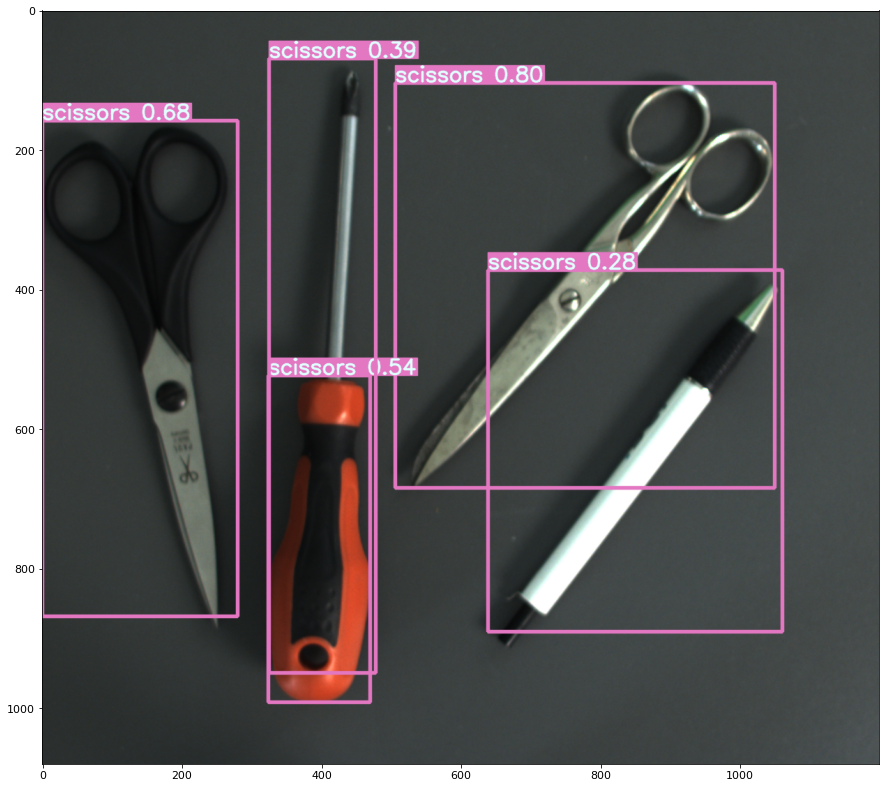

In [21]:
res_img = results.render()[0]
plt.figure(figsize = (15,15))
plt.imshow(res_img)

## Now do something with the results
...

## Make sure all cameras are closed

In [22]:
ids_peak.Library.Close()

## Export...
### ...as executable Python file

* Exports as an executable **.py** file
* Notes-locks as python comments
* Code-blocks as normal python code
* Executes straight from top to bottom

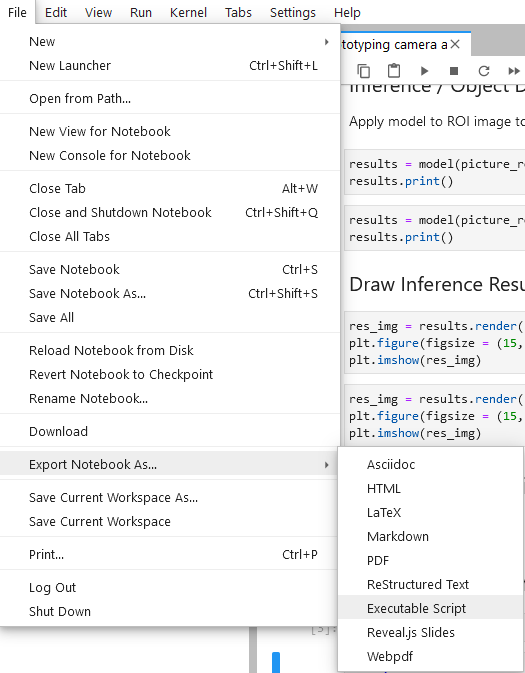 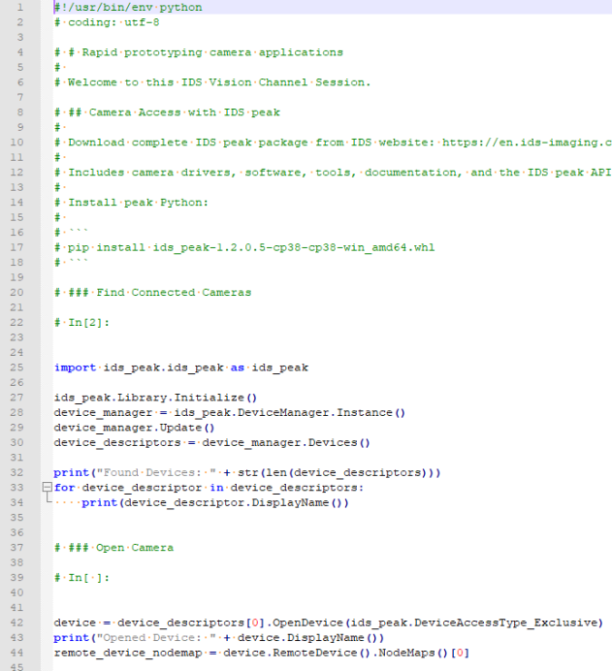

### ...as blueprint for porting 

#### Why port to C++?

* One word: **Perfomance!**
* Python is an interpreted language, therefore much quicker for prototyping
* ...but slower than compiled, highly optimized C++
* C++ is better at multithreading

#### It's easy to port to C++

* peak API has exactly the same interface in Python and C++, making porting very easy
* OpenCV and pyTorch also have C++ interfaces that are similar to Python
* Most other computer vision and machine learning libraries have C++ intrefaces or are originally build in C++

#### Export as HTML file:

* Notes-blocks as formatted HTML
* Code-blocks formatted as code
* Results of code-blocks as well

**=> Complete blueprint for C++ implementation**

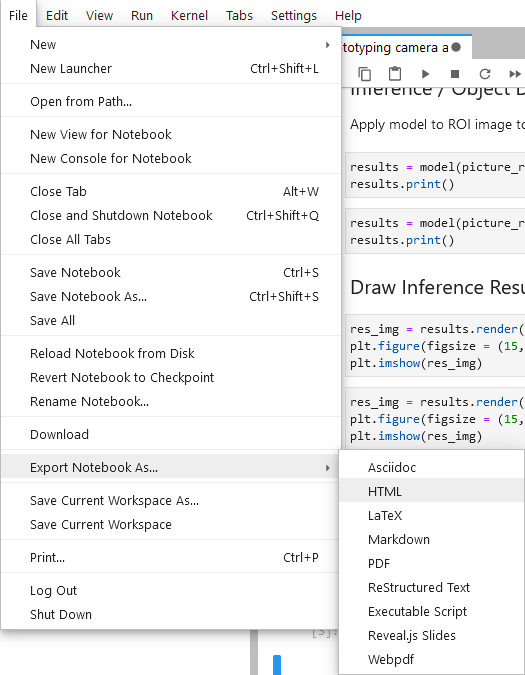 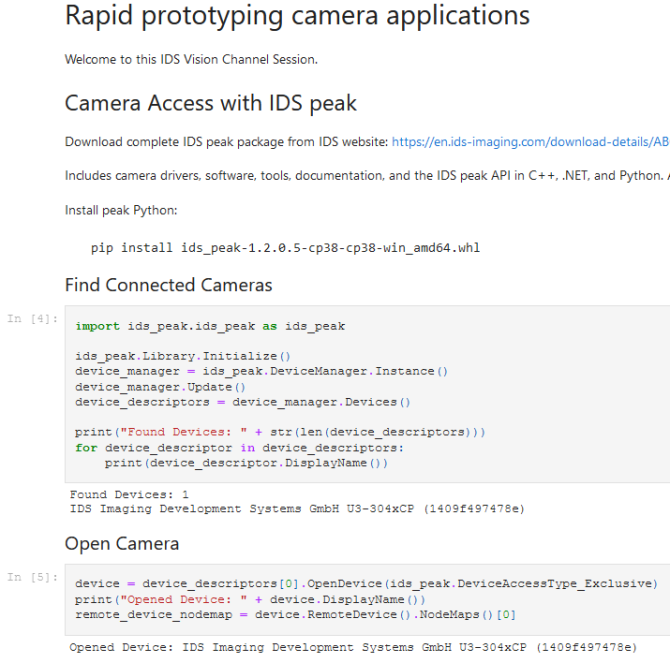